In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from itertools import product
import io

df1 = pd.read_csv("student_dataset.csv")
df2 = pd.read_csv("scholarship_dataset.csv")

df3=df1.merge(df2, how='cross')

In [3]:
def generate_output(row):
    if ((row['CGPA'] >= row['Required_GPA']) & (((row['Education_Level'] =='BS') & (row['Education_Preference']=='Masters')) | ((row['Education_Level'] =='Masters') & (row['Education_Preference']=='PhD')) | ((row['Education_Level'] =='PhD') & (row['Education_Preference']=='PhD')))):
        return 1
    else:
        return 0

In [4]:
df3['Target'] = df3.apply(generate_output, axis=1)

df3.drop('Name', axis=1, inplace=True)
df3.drop('Domain_Area', axis=1, inplace=True)
df3.drop('Eligible_Domain', axis=1, inplace=True)
df3.drop('Budget_Prefrence', axis=1, inplace=True)
df3.drop('Scholarship_Name', axis=1, inplace=True)
df3.drop('Scholarship_Type', axis=1, inplace=True)
df3.drop('Scholarship_Budget', axis=1, inplace=True)
df3.drop('Country_Preference', axis=1, inplace=True)
df3.drop('Country_of_Scholarship', axis=1, inplace=True)

df3.to_csv("combined_dataset.csv", index=False)

In [5]:
print(df3['Target'].value_counts())

0    179554
1     70446
Name: Target, dtype: int64


In [6]:
df3 = pd.read_csv("combined_dataset.csv")

# Split the dataset into features (X) and target variable (y)
X = df3.drop('Target', axis=1)
y = df3['Target']

# One-hot encode categorical columns
categorical_columns = ["Education_Level", "Education_Preference"]

X = pd.get_dummies(X, columns=categorical_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [8]:
# Build a simple neural network model
model = Sequential([
    Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)),
    Dense(6, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)),
    Dense(4, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with a specified number of epochs
epochs = 10 # Adjust the number of epochs as needed
history=model.fit(X_train_scaled, y_train, epochs=epochs, validation_data=(X_test_scaled, y_test),callbacks=[early_stop])

Epoch 1/10
6250/6250 [==============================] - 26s 4ms/step - loss: 0.5679 - accuracy: 0.8128 - val_loss: 0.4294 - val_accuracy: 0.8572
Epoch 2/10
6250/6250 [==============================] - 25s 4ms/step - loss: 0.4033 - accuracy: 0.8592 - val_loss: 0.3833 - val_accuracy: 0.8514
Epoch 3/10
6250/6250 [==============================] - 28s 5ms/step - loss: 0.3693 - accuracy: 0.8666 - val_loss: 0.3575 - val_accuracy: 0.8677
Epoch 4/10
6250/6250 [==============================] - 25s 4ms/step - loss: 0.3509 - accuracy: 0.8722 - val_loss: 0.3425 - val_accuracy: 0.8831
Epoch 5/10
6250/6250 [==============================] - 26s 4ms/step - loss: 0.3392 - accuracy: 0.8755 - val_loss: 0.3324 - val_accuracy: 0.8781
Epoch 6/10
6250/6250 [==============================] - 26s 4ms/step - loss: 0.3311 - accuracy: 0.8771 - val_loss: 0.3262 - val_accuracy: 0.8856
Epoch 7/10
6250/6250 [==============================] - 26s 4ms/step - loss: 0.3247 - accuracy: 0.8787 - val_loss: 0.3199 - val_ac

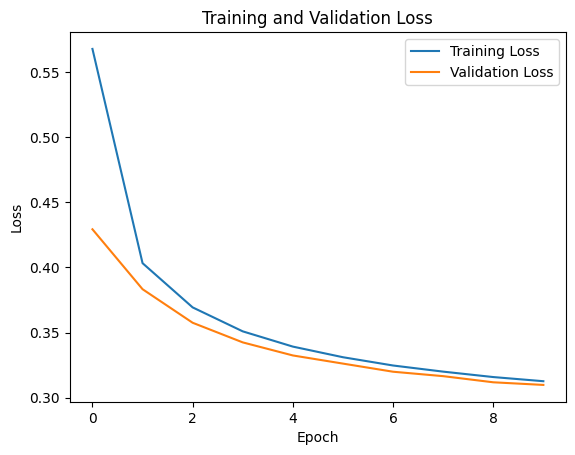

In [9]:
# Accessing loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict probabilities for binary classification
y_pred_prob = model.predict(X_test_scaled)

# Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Ensure y_test and y_pred have the same data type and shape
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

1563/1563 [==============================] - 3s 2ms/step
Accuracy: 0.8793
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     36018
           1       0.70      1.00      0.82     13982

    accuracy                           0.88     50000
   macro avg       0.85      0.92      0.87     50000
weighted avg       0.92      0.88      0.88     50000

Confusion Matrix:
[[29983  6035]
 [    0 13982]]


In [11]:
tf.saved_model.save(model, 'shortlisting_model')


In [12]:
from google.colab import files
import os

dir_to_zip = 'shortlisting_model'
output_filename = 'shortlisting_model.zip'
delete_dir_after_download = "No"

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>